# Looking into mode fitting with pystan
## Simple test of a single mode

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
plt.rcParams['figure.figsize'] = [12,10]

Let's make some simulated data.  We will need a frequency range.  We then create the model of a symmetric Lorentzian in addition to a background.  The limit model is then multiplied by chi squared 2 degrees of freedom noise.

$M(f; \nu, w, h, b, e) = \left( b + \frac{1}{2\pi}\frac{hw}{(\nu - f)^2 + \frac{w^2}{4}} \right) e$

where 

$e \sim \chi^{2}_{2}$.

Text(0,0.5,'Power')

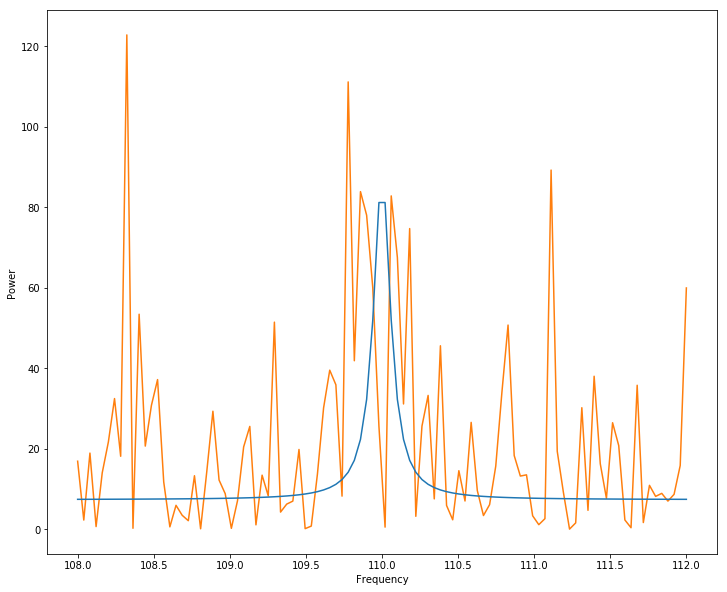

In [45]:
npts = 100
f = np.linspace(108,112,npts)
b = 2.0
h = -1.0
w = -2.0
nu = 110.0
model = np.exp(b) + (np.exp(h)/((nu - f)**2 + (np.exp(w))**2/4))
data = model * np.random.chisquare(2, npts)
fig, ax = plt.subplots()
ax.plot(f, model, zorder=5)
ax.plot(f, data)
ax.set_xlabel('Frequency')
ax.set_ylabel('Power')

So Let's build a STAN model that tries to deal with this.

In [35]:
mode_code = '''
functions {
    real lor(real f, real nu, real h, real w){
        return h / (pow(nu - f, 2) + w^2/4);
    }
}
data {
    int<lower = 0> N;
    vector[N] f;
    vector[N] p;
}
parameters {
    real<lower=108.0, upper=112.0> nu;
    real<lower = -3, upper = 1> w;
    real<lower = -2, upper = 8> h;
    real<lower = -4, upper = 8> b;
}
model {
    vector[N] tmp;
    for (i in 1:N)
        tmp[i] = 0.5 / (exp(b) + lor(f[i], nu, exp(h), exp(w))); 
    p ~ gamma(1, tmp);
}
'''
sm = pystan.StanModel(model_code=mode_code, model_name='Modefit')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL Modefit_b6a454eae818d4994cf923322899732d NOW.


/usr/local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


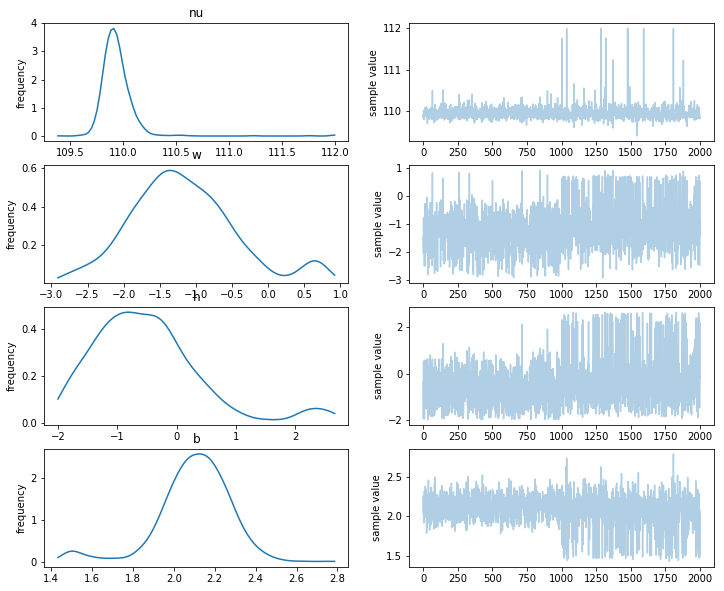

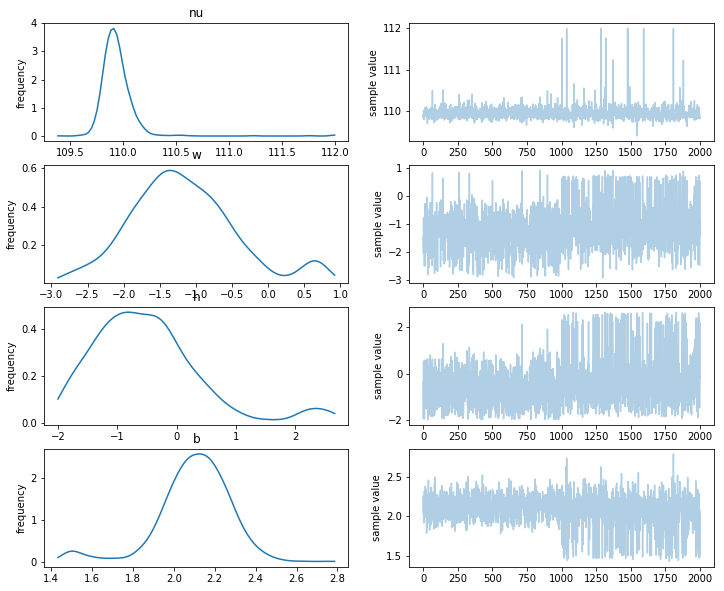

In [46]:
dat = {'N': len(f),
      'f': f,
      'p': data}
fit = sm.sampling(data=dat, iter=2000, chains=2)
fit.plot()

In [47]:
print(fit)

Inference for Stan model: Modefit_b6a454eae818d4994cf923322899732d.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
nu   109.94    0.01   0.17 109.75 109.86 109.92 109.99 110.19    198    1.0
w     -1.17    0.13   0.75  -2.53  -1.66  -1.24  -0.75   0.69     34   1.05
h     -0.48    0.15   0.94  -1.85  -1.14  -0.62  -0.07    2.3     38   1.04
b       2.1    0.03   0.18   1.53   2.01   2.11   2.21    2.4     48   1.03
lp__ -403.0    0.26   2.22 -408.5 -403.9 -402.4 -401.4 -400.5     75   1.02

Samples were drawn using NUTS at Sat Feb 17 14:51:48 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


1.9892441885448573


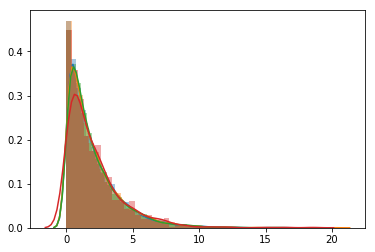

In [5]:
npts = 10000
sns.distplot(np.random.chisquare(2, npts))
sns.distplot(np.random.gamma(1.0, 2.0, npts))
sns.distplot(np.random.exponential(2.0, npts))
print(np.mean(np.random.chisquare(2, npts)))
sns.distplot(data/model)